# College Basketball Deep Learning with Keras

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
import numpy as np

%matplotlib inline

In [7]:
games_df = pd.read_csv('basketball_data/games_season.csv')
games_df.head()

,season,team_1,team_2,home,score_diff,score_1,score_2,won
0,1985,3745,6664,0,17,81,64,1
1,1985,126,7493,1,7,77,70,1
2,1985,288,3593,1,7,63,56,1
3,1985,1846,9881,1,16,70,54,1
4,1985,2675,10298,1,12,86,74,1


In [35]:
games_df.shape

(312178, 8)

In [8]:
tourney = pd.read_csv('basketball_data/games_tourney.csv')
tourney.head()

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won
0,1985,288,73,0,-3,-9,41,50,0
1,1985,5929,73,0,4,6,61,55,1
2,1985,9884,73,0,5,-4,59,63,0
3,1985,73,288,0,3,9,50,41,1
4,1985,3920,410,0,1,-9,54,63,0


In [36]:
tourney.shape

(4234, 9)

The first step in creating a neural network model is to define the Input layer. This layer takes in raw data, usually in the form of numpy arrays. 

The shape of the Input layer defines how many variables the neural network will use. 

For example, if the input data has 10 columns, we'll define an Input layer with a shape of (10,).

In this case, we'll be using only one input in our network.

In [47]:
# Import Input and Dense from keras.layers
from keras.layers import Input, Dense, Embedding, Flatten

In [10]:
# Input layer of shape 1
input_tensor = Input(shape=(1,))

#### NB: Remember that the input layer allows the model to load data.

Once you have an Input layer, the next step is to add a Dense layer.

`Dense layers` learn a weight matrix, where the first dimension of the matrix is the dimension of the input data, and the second dimension is the dimension of the output data. 

Recall that the Input layer has a shape of 1. In this case, the output layer will also have a shape of 1. 

This means that the Dense layer will learn a 1x1 weight matrix. we will add a dense layer to the model, after the input layer.

In [14]:
# Dense layer
output_layer = Dense(1)

# Connecting the dense layer to the input_tensor
output_tensor = output_layer(input_tensor)

#### This network will take the input, apply a linear coefficient to it, and return the result.

The output layer allows our model to make predictions.

In [15]:
# Build the model
from keras.models import Model
model = Model(input_tensor, output_tensor)

Once you've defined an input layer and an output layer, you can build a Keras model. 

The model object is how you tell Keras where the model starts and stops: where data comes in and where predictions come out.

In [16]:
# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

In [19]:
# Import the plotting function
from keras.utils.vis_utils import plot_model

In [24]:
# Summarize the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


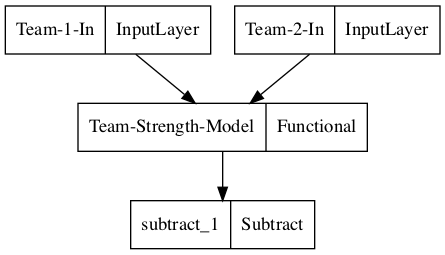

In [56]:
# Plot the model
plot_model(model, to_file='model.png')

# Display the image
# data = plt.imread('model.png')
# plt.imshow(data)
# plt.show()

In [27]:
# spliting data into train and test data
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(tourney['seed_diff'], 
                                                    tourney['score_diff'], test_size=0.3,
                                                   random_state=123)

In [31]:
# fitting the model
model.fit(X_train, y_train,
          epochs=1, batch_size=128, validation_split=0.1, verbose=True)

21/21 [==============================] - 0s 5ms/step - loss: 9.0681 - val_loss: 9.1053


The model has learned something about the basketball data!

In [33]:
model.evaluate(X_test, y_test, verbose=False)

9.497772216796875

Looks like our model makes pretty good predicitions!

### Defining Team Lookup

Shared layers allow a model to use the same weight matrix for multiple steps. so we will build a "team strength" layer that represents each team by a single number. 

we will use this number for both teams in the model. The model will learn a number for each team that works well both when the team is team_1 and when the team is team_2 in the input data.

In [44]:
# Count the unique number of teams
n_teams = games_df['team_1'].unique().shape[0]

# Create an embedding layer
team_lookup = Embedding(input_dim=n_teams,
                        output_dim=1,
                        input_length=1,
                        name='Team-Strength')

The embedding layer is a lot like a dictionary, but the model learns the values for each key.

The team strength lookup has three components: an input, an embedding layer, and a flatten layer that creates the output.

If you wrap these three layers in a model with an input and output, you can re-use that stack of three layers at multiple places.

Note again that the weights for all three layers will be shared everywhere we use them

In [49]:
# Create an input layer for the team ID
teamid_in = Input(shape=(1,))

# Lookup the input in the team strength embedding layer
strength_lookup = team_lookup(teamid_in)

# Flatten the output
strength_lookup_flat = Flatten()(strength_lookup)

# Combine the operations into a single, re-usable model
team_strength_model = Model(teamid_in, strength_lookup_flat, 
                            name='Team-Strength-Model')

Defining two input layers for the two teams in your model. This allows to specify later in the model how the data from each team will be used differently.

In [50]:
# Input layer for team 1
team_in_1 = Input(shape=(1,), name='Team-1-In')

# Separate input layer for team 2
team_in_2 = Input(shape=(1,), name='Team-2-In')

In the games_df dataset, there are 10,888 unique teams. We want to learn a strength rating for each team, such that if any pair of teams plays each other, you can predict the score, even if those two teams have never played before. 

Furthermore, we want the strength rating to be the same, regardless of whether the team is the home team or the away team.

In [51]:
# Lookup team 1 in the team strength model
team_1_strength = team_strength_model(team_in_1)

# Lookup team 2 in the team strength model
team_2_strength = team_strength_model(team_in_2)

Now the model knows how strong each team is.

### Output Layer using Shared Layer

Now that we've looked up how "strong" each team is, we'll subtract the team strengths to determine which team is expected to win the game.

This is a bit like the seeds that the tournament committee uses, which are also a measure of team strength. But rather than using seed differences to predict score differences, we'll use the difference of your own team strength model to predict score differences.

The subtract layer will combine the weights from the two layers by subtracting them.

In [52]:
# Import the Subtract layer from keras
from keras.layers import Subtract

# Create a subtract layer using the inputs from the previous exercise
score_diff = Subtract()([team_1_strength, team_2_strength])

This setup subracts the team strength ratings to determine a winner.

### Model Using Two Inputs and One Output

Now that we have two inputs (team id 1 and team id 2) and output (score difference), we can wrap them up in a model so you can use it later for fitting to data and evaluating on new data.

In [53]:
# Subtraction layer from previous exercise
score_diff = Subtract()([team_1_strength, team_2_strength])

# Create the model
model = Model([team_in_1, team_in_2], score_diff)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

Now the model is finalized and ready to fit to data.

Now that we've defined a complete team strength model, let's fit it to the basketball data! 

Since the model has two inputs now, we need to pass the input data as a list

In [57]:
# Get the team_1 column from the regular season data
input_1 = games_df['team_1']

# Get the team_2 column from the regular season data
input_2 = games_df['team_2']

# Fit the model to input 1 and 2, using score diff as a target
model.fit([input_1, input_2],
          games_df['score_diff'],
          epochs=1,
          batch_size=2048,
          validation_split=0.10,
          verbose=True)

138/138 [==============================] - 1s 4ms/step - loss: 12.1205 - val_loss: 11.8382


The model has learned a strength rating for every team!

#### Let's evaluate the model on this new dataset. 

This evaluation will tell how well we can predict the tournament games, based on a model trained with the regular season data. 

This is interesting because many teams play each other in the tournament that did not play in the regular season, so this is a very good check that the model is not overfitting.

In [58]:
# Get team_1 from the tournament data
input_1 = tourney['team_1']

# Get team_2 from the tournament data
input_2 = tourney['team_2']

# Evaluate the model using these inputs
print(model.evaluate([input_1, input_2], tourney['score_diff'], verbose=False))

11.682107925415039
